# 04. Machine Learning for music playlists: Novelty Detection
This is the 4th post in a series of posts devoted to building music playlists with Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "ballet", "cycling", and "yoga". To solve that problem I use ML classification algorithms.    

Previous posts cover the following steps:
* [00_Overview](https://github.com/Tykovka/itunes-music-analysis/blob/master/00_Overview.ipynb) — Overview of the analysis, its goals and methods, installation notes.  
* [01_Data_preparation](https://github.com/Tykovka/itunes-music-analysis/blob/master/01_Data_preparation.ipynb) — Data gathering and cleaning.  
* [02_Data_visualisation](https://github.com/Tykovka/itunes-music-analysis/blob/master/02_Data_Visualisation.ipynb) — Visualisation and overview of data.  
* [03_Preprocessing](https://github.com/Tykovka/itunes-music-analysis/blob/master/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn machine learning algorithms. 

As a result of the above manipulations I have two datasets: 
* training set contains 143 tracks labelled with one of the three classes: "ballet", "cycling", "yoga";
* test dataset contains 536 non-labelled tracks.  

The three classes I have in the training set don't cover all classes of music I have in my iTunes music library (test set). Because of that I can't apply a classification algorithm to the whole test set as it will also assign a class to irrelevant tracks.  

In this notebook I'm going to identify tracks in the non-labelled dataset that fit classes in the training dataset and eliminate tracks that completely unfit the classes.  

#### Contents of the notebook
* [One-Class SVM for novelty detection](#04a.-One-Class-SVM-for-novelty-detection), where I provide the algorithm with the whole training dataset — three classes at once — to choose the boundary.
* [Novelty detection by one class](#04b.-Novelty-detection-by-one-class), where I provide the algorithm only with one class at a time.
* [Summary](#Summary).

I start with importing modules required in this notebook.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

#### Read in data
In this notebook I use preprocessed data, which are numpy arrays of standardised data.  
I store data in HDF5 file format. To read it I use h5py library.

In [2]:
import h5py

# open the file 'music_data.h5' in read-only mode
with h5py.File('music_data.h5','r') as hf:
    train_std = np.array(hf.get('train_std'))
    test_std = np.array(hf.get('test_std'))

In [3]:
# shape of sets
print "Training set:", train_std.shape
print "Test set:", test_std.shape

Training set: (143, 11)
Test set: (536, 11)


## 04a. One-Class SVM for novelty detection
I use [One-Class SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) unsupervised algorithm to identify tracks in the non-labelled dataset that fit classes in the training dataset. One-Class SVM is used for novelty detection, that is, given a training set, it will detect the soft boundary of that set so as to classify new points (a test set) as belonging to that set or not. It's important to point out that the algorithm treats the training data as not polluted by outliers.  

In this part of the notebook I will provide the algorithm with the whole training dataset — with the three classes at once — to choose the boundary.

I use the following parameters: radial basis function, or 'rbf', kernel; 'nu' value has been chosen by trial and error method calculating the error level. 'nu' value is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.

In [4]:
from sklearn import svm

# fit the model
svm_model = svm.OneClassSVM(kernel="rbf", nu=0.07)
svm_model.fit(train_std)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.07, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

New observations, or test data, can now be sorted as inliers or outliers with a predict method. Inliers are labelled 1 while outliers are labelled -1.

In [5]:
# make prediction
test_novelty_pred = svm_model.predict(test_std)

# number of tracks outside set boudaries
n_error_test = test_novelty_pred[test_novelty_pred == -1].size

print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((test_novelty_pred.size - n_error_test), 
               n_error_test))

Number of tracks that match the training set: 408.
Number of tracks outside set boudaries: 128.


To assess the error of the model I make a prediction for the training set. 

In [6]:
# calculate the error
error = svm_model.predict(train_std)
print error[error == -1].size

18


That means that 18 tracks, or 12.5%, in the training set were identified as outliers by the model, trained with that same set. This is rather high for the error. I plot the data to see what's going on under the hood.

## Make a plot
To visualise the soft boundary of the training set that is built by One-Class SVM algorithm I make a plot.  

#### Dimensionality reduction
Since it's hard to plot 11 dimensions in a 2-dimensional space, I need to perform dimensionality reduction with a PCA algorithm. Essentially, the PCA algorithm finds the optimal stretch and rotation in 11-dimensional space that allows to see the layout of classes.   

I use 2-dimensional data from the previous notebook [03_Preprocessing](https://github.com/Tykovka/itunes-music-analysis/blob/master/03_Preprocessing.ipynb). 

In [7]:
# read in 2-dimensional data
with h5py.File('music_data.h5','r') as hf:
    train_2d = np.array(hf.get('train_2d'))
    test_2d = np.array(hf.get('test_2d'))

In [8]:
# shape of sets
print "Training set:", train_2d.shape
print "Test set:", test_2d.shape

Training set: (143, 2)
Test set: (536, 2)


I retrain One-Class SVM algorithm with 2D data, otherwise, the decision_function will raise an error when plotting it in 2D space.  
I use [base.clone](http://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html) function to copy the model in an estimator without actually copying attached data. It yields a new estimator with the same parameters that has not been fit to any data.

In [9]:
from sklearn.base import clone

# copy the model
svm_model_2d = clone(svm_model)

# train the model on a 2d data
svm_model_2d.fit(train_2d)

# make prediction
test_novelty_2d = svm_model_2d.predict(test_2d)

# number of tracks outside set boudaries
n_error_test_2d = test_novelty_2d[test_novelty_2d == -1].size

print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((test_novelty_2d.size - n_error_test_2d), 
               n_error_test_2d))

Number of tracks that match the training set: 446.
Number of tracks outside set boudaries: 90.


Prediction for the 2-dimensional set differs from the prediction made for 11-dimensional data. However, this is not really important for plotting the data.

#### Plotting 2D data
Now the data are ready to be plotted. 

In [12]:
def plot_oneclass_svm(model, train_data, test_data, plt_title, ax):
    """Plot decision boundary and predictions 
    made by One-Class SVM algorithm.
    """
    # create a mesh to plot in
    x_min, x_max = train_data[:, 0].min() - 5, train_data[:, 0].max() + 5
    y_min, y_max = train_data[:, 1].min() - 7, train_data[:, 1].max() + 6
    # step size in the mesh
    h = 0.05 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_title(plt_title, {'fontsize': 14})

    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 30), cmap=plt.cm.gist_earth)
    a = ax.contour(xx, yy, Z, levels=[0], linewidths=1, colors='grey')
    ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='grey', alpha=0.4)

    b1 = ax.scatter(test_data[:, 0], test_data[:, 1], c='rosybrown', s=10) # test set
    b2 = ax.scatter(train_data[:, 0], train_data[:, 1], c='aqua', s=10) # train set
    
    ax.set_xlim((-5, 6))
    ax.set_ylim((-6, 6))
    
    plt.legend([a.collections[0], b1, b2],
               ["Learned Frontier", "Test Observations",
                "Training Observations"], 
               bbox_to_anchor=(1.05, 1), borderaxespad=0.,
               loc=2,
               prop=matplotlib.font_manager.FontProperties(size=12))

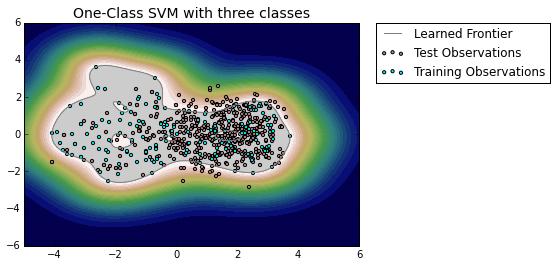

In [13]:
fig, ax = plt.subplots()
plot_oneclass_svm(svm_model_2d, train_2d, test_2d, "One-Class SVM with three classes", ax=ax)

This plot shows how One-Class SVM algorithm made the decision about which side of the boundary every track from the test set lays on. On the plot, 446 tracks lay within the boundary and 90 tracks were left outside. When applied to the full 11-dimensional dataset, the result is a bit different. 408 tracks in the test set match the training, or labelled, data, and 128 tracks don't. 

In the following posts I'm going to work with these 408 tracks that were identified by One-Class SVM algorithm as a good match to the three classes. I record the result of novelty detection algorithm to the test set and then save on disc. Thus it will be more convenient to load data in the future posts, avoiding most preprocessing steps.  

But first I convert the prediction array to a 2-dimensional numpy array. 

In [14]:
# add novelty results to the set
# convert test_novelty_pred from a 1d array into a 2d array
print ('Shape before: {}, number of dimensions: {}'
        .format(test_novelty_pred.shape, test_novelty_pred.ndim))
print ('Shape after the magic: {}, number of dimensions: {}'
       .format(test_novelty_pred[:, None].shape, test_novelty_pred[:, None].ndim))

Shape before: (536,), number of dimensions: 1
Shape after the magic: (536, 1), number of dimensions: 2


In [15]:
# create a new array with results
test_svm = np.concatenate((test_std, test_novelty_pred[:, None]), 1)
print "Test set shape before concatenation:", test_std.shape
print "Test set shape after concatenation:", test_svm.shape

Test set shape before concatenation: (536, 11)
Test set shape after concatenation: (536, 12)


In [22]:
# open the file 'music_data.h5' in append mode
with h5py.File('music_data.h5', 'a') as hf:
     hf.create_dataset('test_svm', data=test_svm)

## 04b. Novelty detection by one class
As an experiment, I'm going to provide One-Class SVM algorithm not with the whole training data but only with one class at a time. Thus the algorithm will choose in the test set only observations that match that particular class. I will also filter for every class unique inliers that match only that one class.  

In the following notebooks I will compare the result of this approach with ML classification algorithms.

#### Data preparation
I make numpy arrays for each class.

In [23]:
# load target labels
with h5py.File('music_data.h5','r') as hf:
    target = np.array(hf.get('target'))

In [25]:
# make Numpy arrays for each class
ballet = train_std[target == 0]
cycling = train_std[target == 1]
yoga = train_std[target == 2]

I make a function to apply One-Class SVM algorithm to the class. The novelty_detection_summary function is responsible for printing the summary.

In [26]:
def new_observations_by_class(model, data, test_data):
    """Identify matching observations
    in the test set.
    Return a Numpy array where
    inliers are 1, outliers are -1. 
    """
    # clone the model
    model_c = clone(model)
    
    # fit the model
    model_c.fit(data)
    
    # make prediction
    novelty = model_c.predict(test_data)
    
    return novelty

def novelty_detection_summary(novelty, label):
    # number of tracks within boundaries
    n = novelty[novelty == 1].size

    # number of tracks outside set boudaries
    n_error = novelty[novelty == -1].size

    print ("Number of tracks that match the {0} class: {1}."
           "\nNumber of tracks outside the class boudaries: {2}."
           .format(label, n, n_error))

#### One-Class SVM algorithm — the ballet class

In [27]:
# make prediction
nov_ballet = new_observations_by_class(svm_model, 
                                       ballet, 
                                       test_std)

# print the result
novelty_detection_summary(nov_ballet, 'ballet')

Number of tracks that match the ballet class: 132.
Number of tracks outside the class boudaries: 404.


#### One-Class SVM algorithm — the cycling class

In [28]:
# make prediction
nov_cycling = new_observations_by_class(svm_model, 
                                        cycling, 
                                        test_std)

# print the result
novelty_detection_summary(nov_cycling, 'cycling')

Number of tracks that match the cycling class: 225.
Number of tracks outside the class boudaries: 311.


#### One-Class SVM algorithm — the yoga class

In [29]:
# make prediction
nov_yoga = new_observations_by_class(svm_model, 
                                     yoga, test_std)

# print the result
novelty_detection_summary(nov_yoga, 'yoga')

Number of tracks that match the yoga class: 77.
Number of tracks outside the class boudaries: 459.


#### Unique new observations 
I want to make a set with unique new observations for every class. To do that I exclude from the test set observations matching two other classes.

In [33]:
ballet_unique = test_std[(nov_ballet == 1) &
                        (nov_cycling == -1) &
                        (nov_yoga == -1)]

print ("Number of tracks that match the {0} class: {1}."
       "\nNumber of unique tracks that match only the {0} class: {2}."
       .format('ballet', nov_ballet[nov_ballet == 1].size,
              len(ballet_unique)))

Number of tracks that match the ballet class: 132.
Number of unique tracks that match only the ballet class: 45.


In [34]:
cycling_unique = test_std[(nov_cycling == 1) &
                          (nov_ballet == -1) &
                          (nov_yoga == -1)]

print ("Number of tracks that match the {0} class: {1}."
       "\nNumber of unique tracks that match only the {0} class: {2}."
       .format('cycling', nov_cycling[nov_cycling == 1].size,
              len(cycling_unique)))

Number of tracks that match the cycling class: 225.
Number of unique tracks that match only the cycling class: 185.


In [35]:
yoga_unique = test_std[(nov_yoga == 1) &
                       (nov_cycling == -1) &
                       (nov_ballet == -1)]

print ("Number of tracks that match the {0} class: {1}."
       "\nNumber of unique tracks that match only the {0} class: {2}."
       .format('yoga', nov_yoga[nov_yoga == 1].size,
              len(yoga_unique)))

Number of tracks that match the yoga class: 77.
Number of unique tracks that match only the yoga class: 21.


In [36]:
print ("Sum of new observations equals to {}."
       .format(len(test_std[(nov_ballet == 1) | 
                            (nov_cycling == 1) | 
                            (nov_yoga == 1)])))
       
print ("Sum of unique new observations equals to {}."
       .format(len(ballet_unique) + 
               len(cycling_unique) + 
               len(yoga_unique)))

Sum of new observations equals to 338.
Sum of unique new observations equals to 251.


#### Save the data
I save the resulting sets with unique observations on disc. I use the grouping option of HDF5 format. The data saved into HDF5 files can be organized in groups. Groups are like subfolders, they are the basic container mechanism.

In [47]:
with h5py.File('music_data.h5', 'a') as hf:
    g1 = hf.create_group('unique_svm')
    g1.create_dataset('ballet_unique', data = ballet_unique)
    g1.create_dataset('cycling_unique', data = cycling_unique)
    g1.create_dataset('yoga_unique', data = yoga_unique)

When One-Class SVM algorithm is provided with labelled data class by class and not all classes together, the soft boundary is tighter and the prediction is narrower. When I provided the algorithm with all classes in one go, 408 track were chosen as matching. When I provided it with classes one by one, the sum of matching tracks reduced to 338, where only 251 tracks were assigned only one class. 

## Make a plot
It turned out to be quite challenging to plot that boundary in a 2D space. I attempted to use the same approach as in the 4a part of the notebook, that is to reduce dimensions of both sets to 2D using PCA algorithm, retrain the One-Class SVM algorithm with the new 2D data, plot the result. However, when I apply One-Class SVM algorithm to a 2D data, the prediction is few times higher than for the 11D data. 

### One-Class SVM with 2D data
I retrain PCA algorithm with every class separately because this way the algorithm will find a better projection for the class.

In [37]:
def reduce_dimensions(train_data, test_data):
    """Perform PCA to reduce the dimensionality
    of both sets.
    Returns 2D sets.
    """
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2).fit(train_data)
    train_2d = pca.transform(train_data)
    test_2d = pca.transform(test_data)

    return train_2d, test_2d

In [38]:
# make 2D arrays for each class
ballet_2d, test_ballet_2d = reduce_dimensions(ballet, test_std)
cycling_2d, test_cycling_2d = reduce_dimensions(cycling, test_std)
yoga_2d, test_yoga_2d = reduce_dimensions(yoga, test_std)

#### Predictions for 2D data
##### The ballet class

In [39]:
# clone the model
svm_model_ballet = clone(svm_model)

# train the model on a 2d data
svm_model_ballet.fit(ballet_2d)

# make prediction
ballet_pred_2d = svm_model_ballet.predict(test_ballet_2d)

print "2-dimensional data"
novelty_detection_summary(ballet_pred_2d, 'ballet')

2-dimensional data
Number of tracks that match the ballet class: 329.
Number of tracks outside the class boudaries: 207.


##### The cycling class

In [40]:
# clone the model
svm_model_cycling = clone(svm_model)

# train the model on a 2d data
svm_model_cycling.fit(cycling_2d)

# make prediction
cycling_pred_2d = svm_model_cycling.predict(test_cycling_2d)

print "2-dimensional data"
novelty_detection_summary(cycling_pred_2d, 'cycling')

2-dimensional data
Number of tracks that match the cycling class: 356.
Number of tracks outside the class boudaries: 180.


##### The yoga class

In [41]:
# copy the model
svm_model_yoga = clone(svm_model)

# train the model on a 2d data
svm_model_yoga.fit(yoga_2d)

# make prediction
yoga_pred_2d = svm_model_yoga.predict(test_yoga_2d)

print "2-dimensional data"
novelty_detection_summary(yoga_pred_2d, 'yoga')

2-dimensional data
Number of tracks that match the yoga class: 302.
Number of tracks outside the class boudaries: 234.


#### Plot 2D data

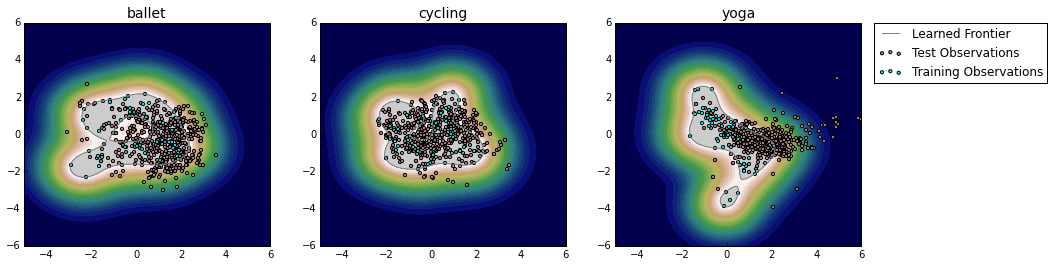

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))

for n,m,ax,d,t in zip(('ballet', 'cycling', 'yoga'), #class labels
                        (svm_model_ballet, svm_model_cycling, svm_model_yoga), #  model
                        (ax1, ax2, ax3),
                        (ballet_2d, cycling_2d, yoga_2d), # class data
                        (test_ballet_2d, test_cycling_2d, test_yoga_2d)): # test data
    plot_oneclass_svm(m, d, t, n, ax)

The plot above doesn't really represent the decision boundary of One-Class SVM algorithm. The result for the 11-dimensional data differs a lot from the 2D data. But still the plot gives some intuition about the prediction logic. 

## Summary
In this notebook, I applied One-Class SVM algorithm to identify tracks in the non-labelled dataset that fit classes in the training dataset and eliminate tracks that completely unfit the classes. 

In the first part, part 'a', of the notebook I provided the algorithm with the whole training dataset — with the three classes at once — to choose the boundary. As a result, 408 tracks were chosen from the test set as matching the training set.  

In the 'b' part of the notebook, I provided the algorithm only with one class at a time. As a result of this approach only 338 tracks were chosen from the test set as matching the training set, where 132 tracks were identified as belonging to the ballet class, 225 tracks — to the cycling class, and 77 tracks — to the yoga class. Some tracks were assigned more than one class.

In the following notebooks I will apply different machine learning classification algorithms to label 408 tracks with one of the three classes — "cycling", "ballet", and "yoga". In the end, I will compare the results with unique predictions made by One-Class SVM algorithm trained with one class at a time.